# Setup and Install

In [ ]:
import os
import glob
import shutil
import random
import gc
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO, RTDETR, settings
from IPython.display import Image, display
from google.colab import drive
from roboflow import Roboflow
import datetime

In [ ]:
#!pip install roboflow ultralytics

# YOLOV11S Training

In [ ]:
drive.mount('/content/drive')

# Save Paths for Drive
drive_project_root = '/content/drive/MyDrive/Deep_Learning'
drive_weights_dir = os.path.join(drive_project_root, 'weights')
drive_runs_dir = os.path.join(drive_project_root, 'runs')

# Create directories if they do not exist
os.makedirs(drive_weights_dir, exist_ok=True)
os.makedirs(drive_runs_dir, exist_ok=True)

settings.update({'datasets_dir': '/content/datasets'})

def download_data_fast():
    print("Downloading dataset from Roboflow to local Colab disk")

    rf = Roboflow(api_key="8gFJp7Eu2sWslubjUHwI") # API Key from Roboflow
    project = rf.workspace("visualizan2").project("c1-zhnfm")
    version = project.version(1)

    # This downloads the dataset under /content/datasets
    dataset = version.download("yolov11")

    print(f"Dataset ready at: {dataset.location}")
    return dataset, f"{dataset.location}/data.yaml"

# Start download
dataset_obj, data_yaml_path = download_data_fast()

local_dataset = '/content/local_dataset'

def merge_datasets(source_root, target_root):
    # Iterate through 'train', 'valid', and 'test' sets
    for subset in ['train', 'valid', 'test']:
        for folder in ['images', 'labels']:
            source_dir = os.path.join(source_root, subset, folder)
            target_dir = os.path.join(target_root, subset, folder)

            # Check if source directory exists
            if os.path.exists(source_dir) and os.path.exists(target_dir):
                files = os.listdir(source_dir)

                for file_name in files:
                    full_file_name = os.path.join(source_dir, file_name)
                    if os.path.isfile(full_file_name):
                        shutil.copy(full_file_name, target_dir)
            else:
                pass

# Check if manual path exists and run the merge
if os.path.exists(local_dataset):
    merge_datasets(local_dataset, dataset_obj.location)
else:
    print(f"WARNING: local dataset path not found: {local_dataset}. Proceeding with Roboflow data only.")

# yolo11 small model training
model = YOLO('yolo11s.pt')

run_name = 'chess_yolo11s_fast_v1'

results = model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    optimizer='AdamW',
    lr0=0.001,
    cos_lr=True,
    project='/content/runs/detect',
    name=run_name,
    seed=42,
    patience=15,
    plots=True
)


def backup_to_drive():
    print("Training completed. Backing up results to Google Drive")

    # Local results directory
    local_dir = f'/content/runs/detect/{run_name}'

    # Destination directory on Drive with timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    drive_dest = os.path.join(drive_runs_dir, f"{run_name}_{timestamp}")

    # Copy entire run folder
    shutil.copytree(local_dir, drive_dest)

    best_pt = os.path.join(local_dir, 'weights', 'best.pt') # Path to best model weights
    if os.path.exists(best_pt):
        shutil.copy(best_pt, os.path.join(drive_weights_dir, f"best_{run_name}.pt")) # Copy best weights separately
        print(f"Best model copied to: {drive_weights_dir}")

backup_to_drive()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to C1-1 in yolov11:: 100%|██████████| 19546/19546 [00:05<00:00, 3336.59it/s]


Dataset ready at: /content/C1-1
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/C1-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=chess_yolo11s_fast_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patien

# Show Training Metrics

 Inspecting results from: /content/drive/MyDrive/Deep_Learning/runs/chess_yolo11s_fast_v1_20251224_1304
Test images found in Drive: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

==================== 1. TRAINING METRICS ====================

--- Loss & Metrics Curves ---


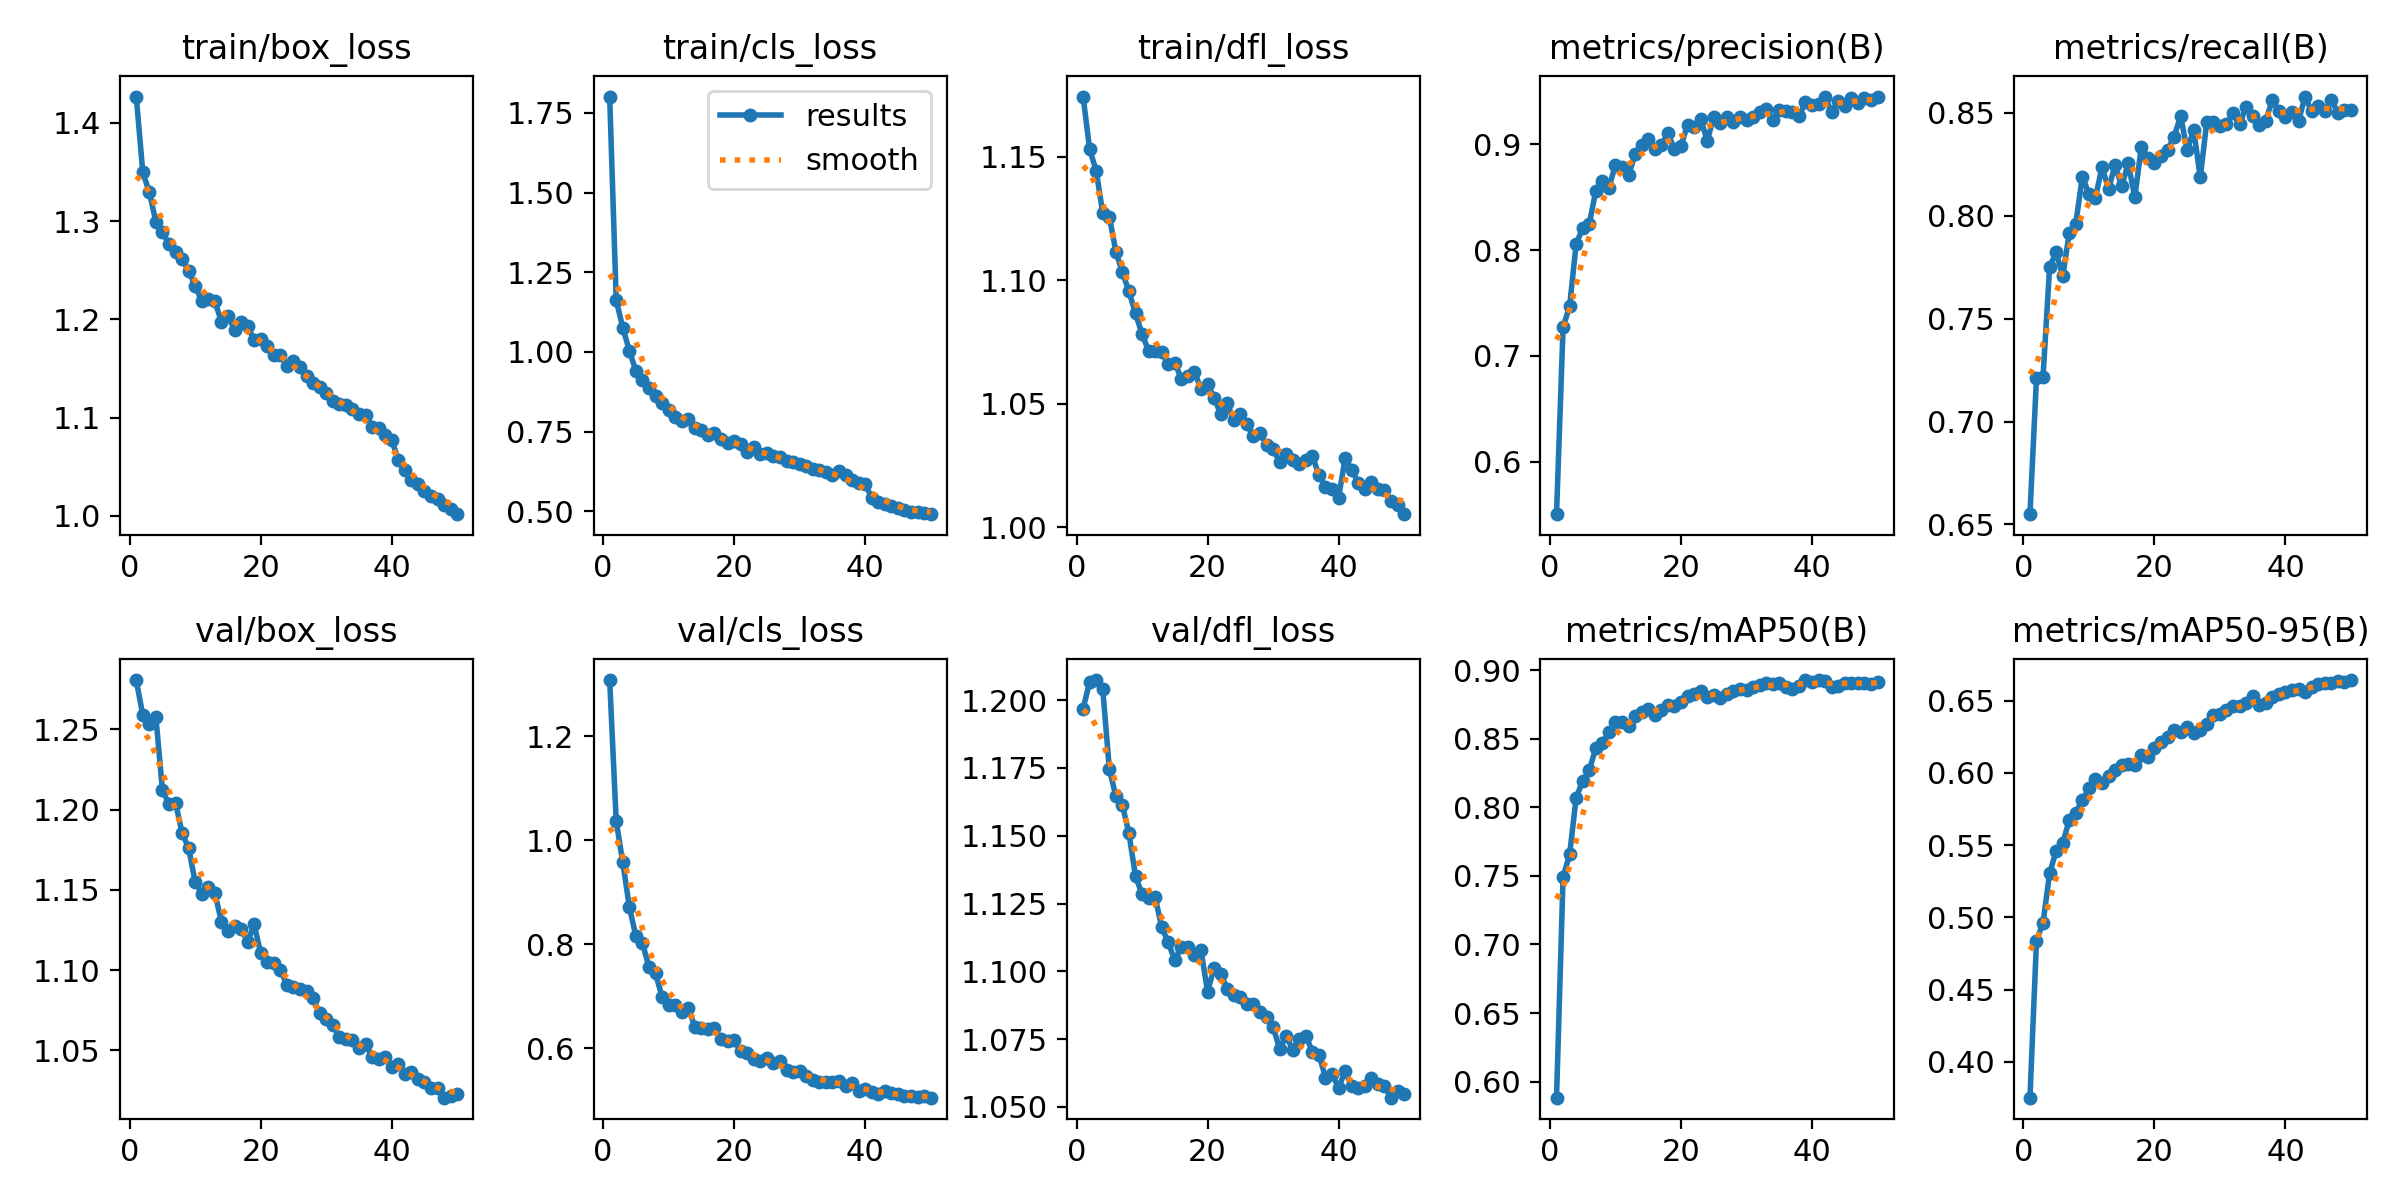


--- Confusion Matrix (Normalized) ---


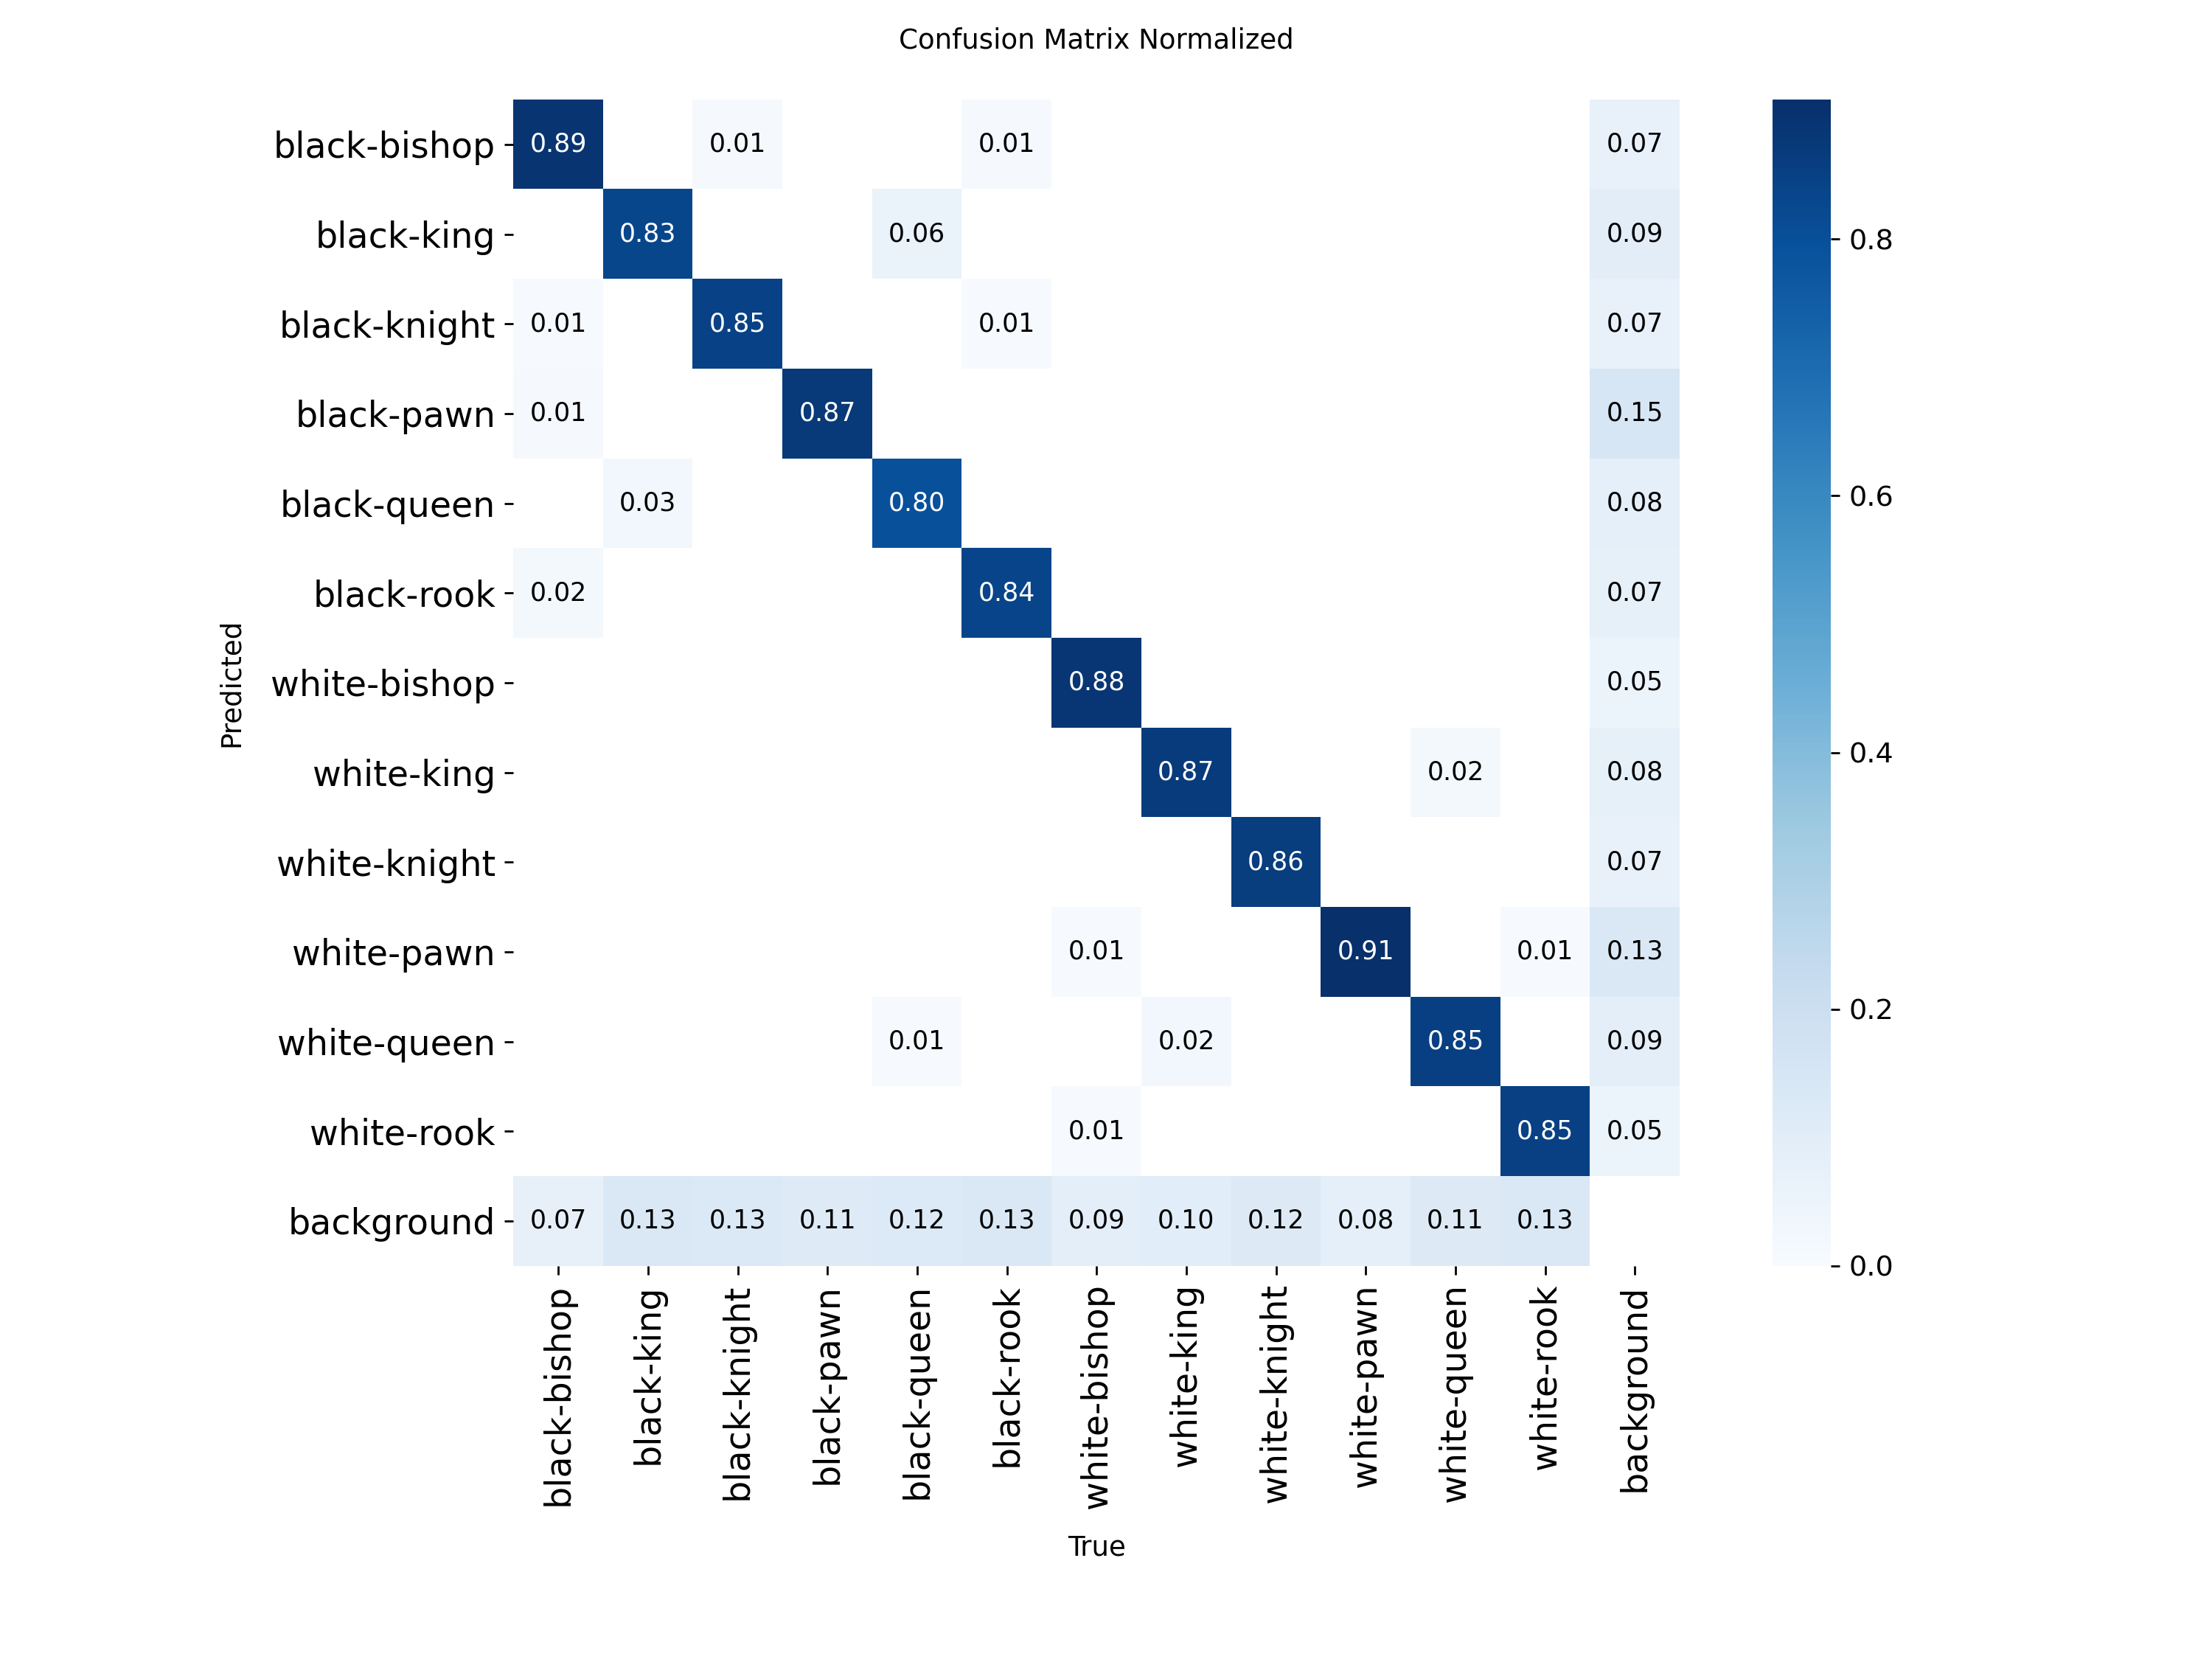

Could not find F1_curve.png. (Check if training finished successfully)

==================== 2. VISUAL PREDICTIONS (TEST SET) ====================


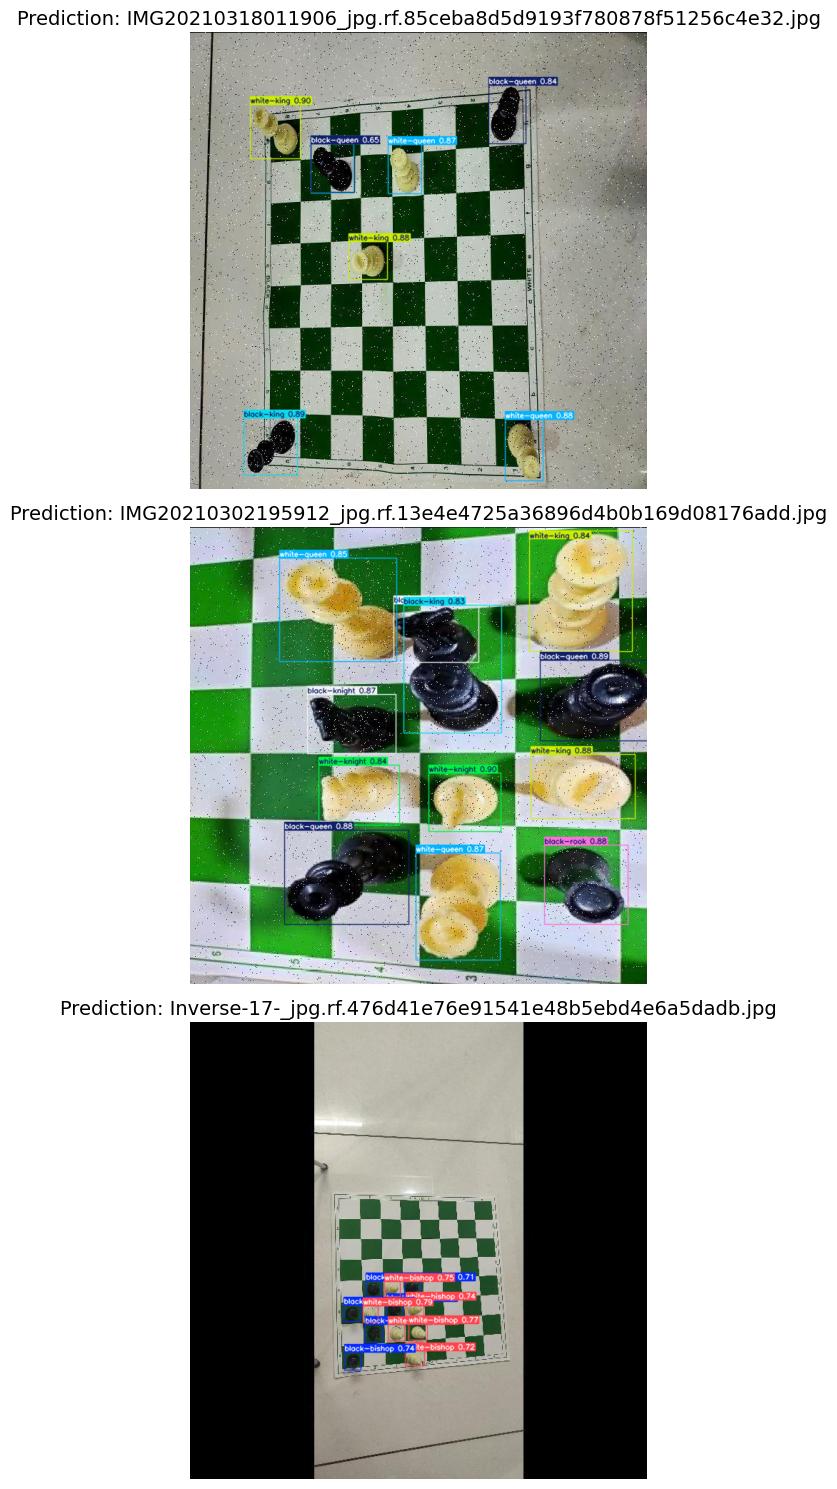

In [ ]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

run_name = 'chess_yolo11s_fast_v1_20251224_1304'

drive_root = '/content/drive/MyDrive/Deep_Learning'

run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

print(f" Inspecting results from: {run_dir}")

drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images') # locate test images
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    test_images_path = found_drive_test[0]
    print(f"Test images found in Drive: {test_images_path}")
else:
    # Fallback: Check local storage (if you just downloaded data)
    local_test_path = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(local_test_path):
         local_test_path = '/content/datasets/c1-zhnfm-1/valid/images'
    test_images_path = local_test_path
    print(f"Test images found locally: {test_images_path}")


def display_training_metrics(): # Display training metrics from ultralytics default plots

    print("\n" + "="*20 + " 1. TRAINING METRICS " + "="*20)

    # List of key plots to display
    plots_to_show = [
        ('results.png', 'Loss & Metrics Curves'),
        ('confusion_matrix_normalized.png', 'Confusion Matrix (Normalized)'),
        ('F1_curve.png', 'F1-Confidence Curve')
    ]

    for filename, title in plots_to_show:
        filepath = os.path.join(run_dir, filename)
        if os.path.exists(filepath):
            print(f"\n--- {title} ---")
            display(Image(filename=filepath, width=800))
        else:
            print(f"Could not find {filename}. (Check if training finished successfully)")

def run_visual_inference(num_images=3):
    
    print("\n" + "="*20 + " 2. VISUAL PREDICTIONS (TEST SET) " + "="*20)

    # check if weights exist
    if not os.path.exists(best_model_path):
        print(f"Best model weights not found at: {best_model_path}")
        return

    # Load the best trained model from drive
    model = YOLO(best_model_path)

    # Get all images
    all_images = glob.glob(f"{test_images_path}/*.jpg")

    if len(all_images) == 0:
        print(f"No images found in {test_images_path}")
        return

    # Select random images
    selected_images = random.sample(all_images, min(len(all_images), num_images))

    # Run Inference
    results = model.predict(
        source=selected_images,
        conf=0.25,      # Confidence threshold
        iou=0.45,      
        save=False,     
        verbose=False
    )

    plt.figure(figsize=(15, 5 * num_images))

    for i, r in enumerate(results):
        im_array = r.plot(line_width=1, font_size=1)
        im_rgb = im_array[..., ::-1] # BGR to RGB

        plt.subplot(num_images, 1, i + 1)
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.title(f"Prediction: {os.path.basename(selected_images[i])}", fontsize=14)

    plt.tight_layout()
    plt.show()

display_training_metrics()
run_visual_inference(num_images=3)

# Compare Labels vs Predictions

Target directory: /content/drive/MyDrive/Deep_Learning/runs/chess_yolo11s_fast_v1_20251224_1304
Run folder found. Starting analysis...
Loading test images from Drive: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

=============== TRAINING RESULT: GROUND TRUTH vs PREDICTION ===============


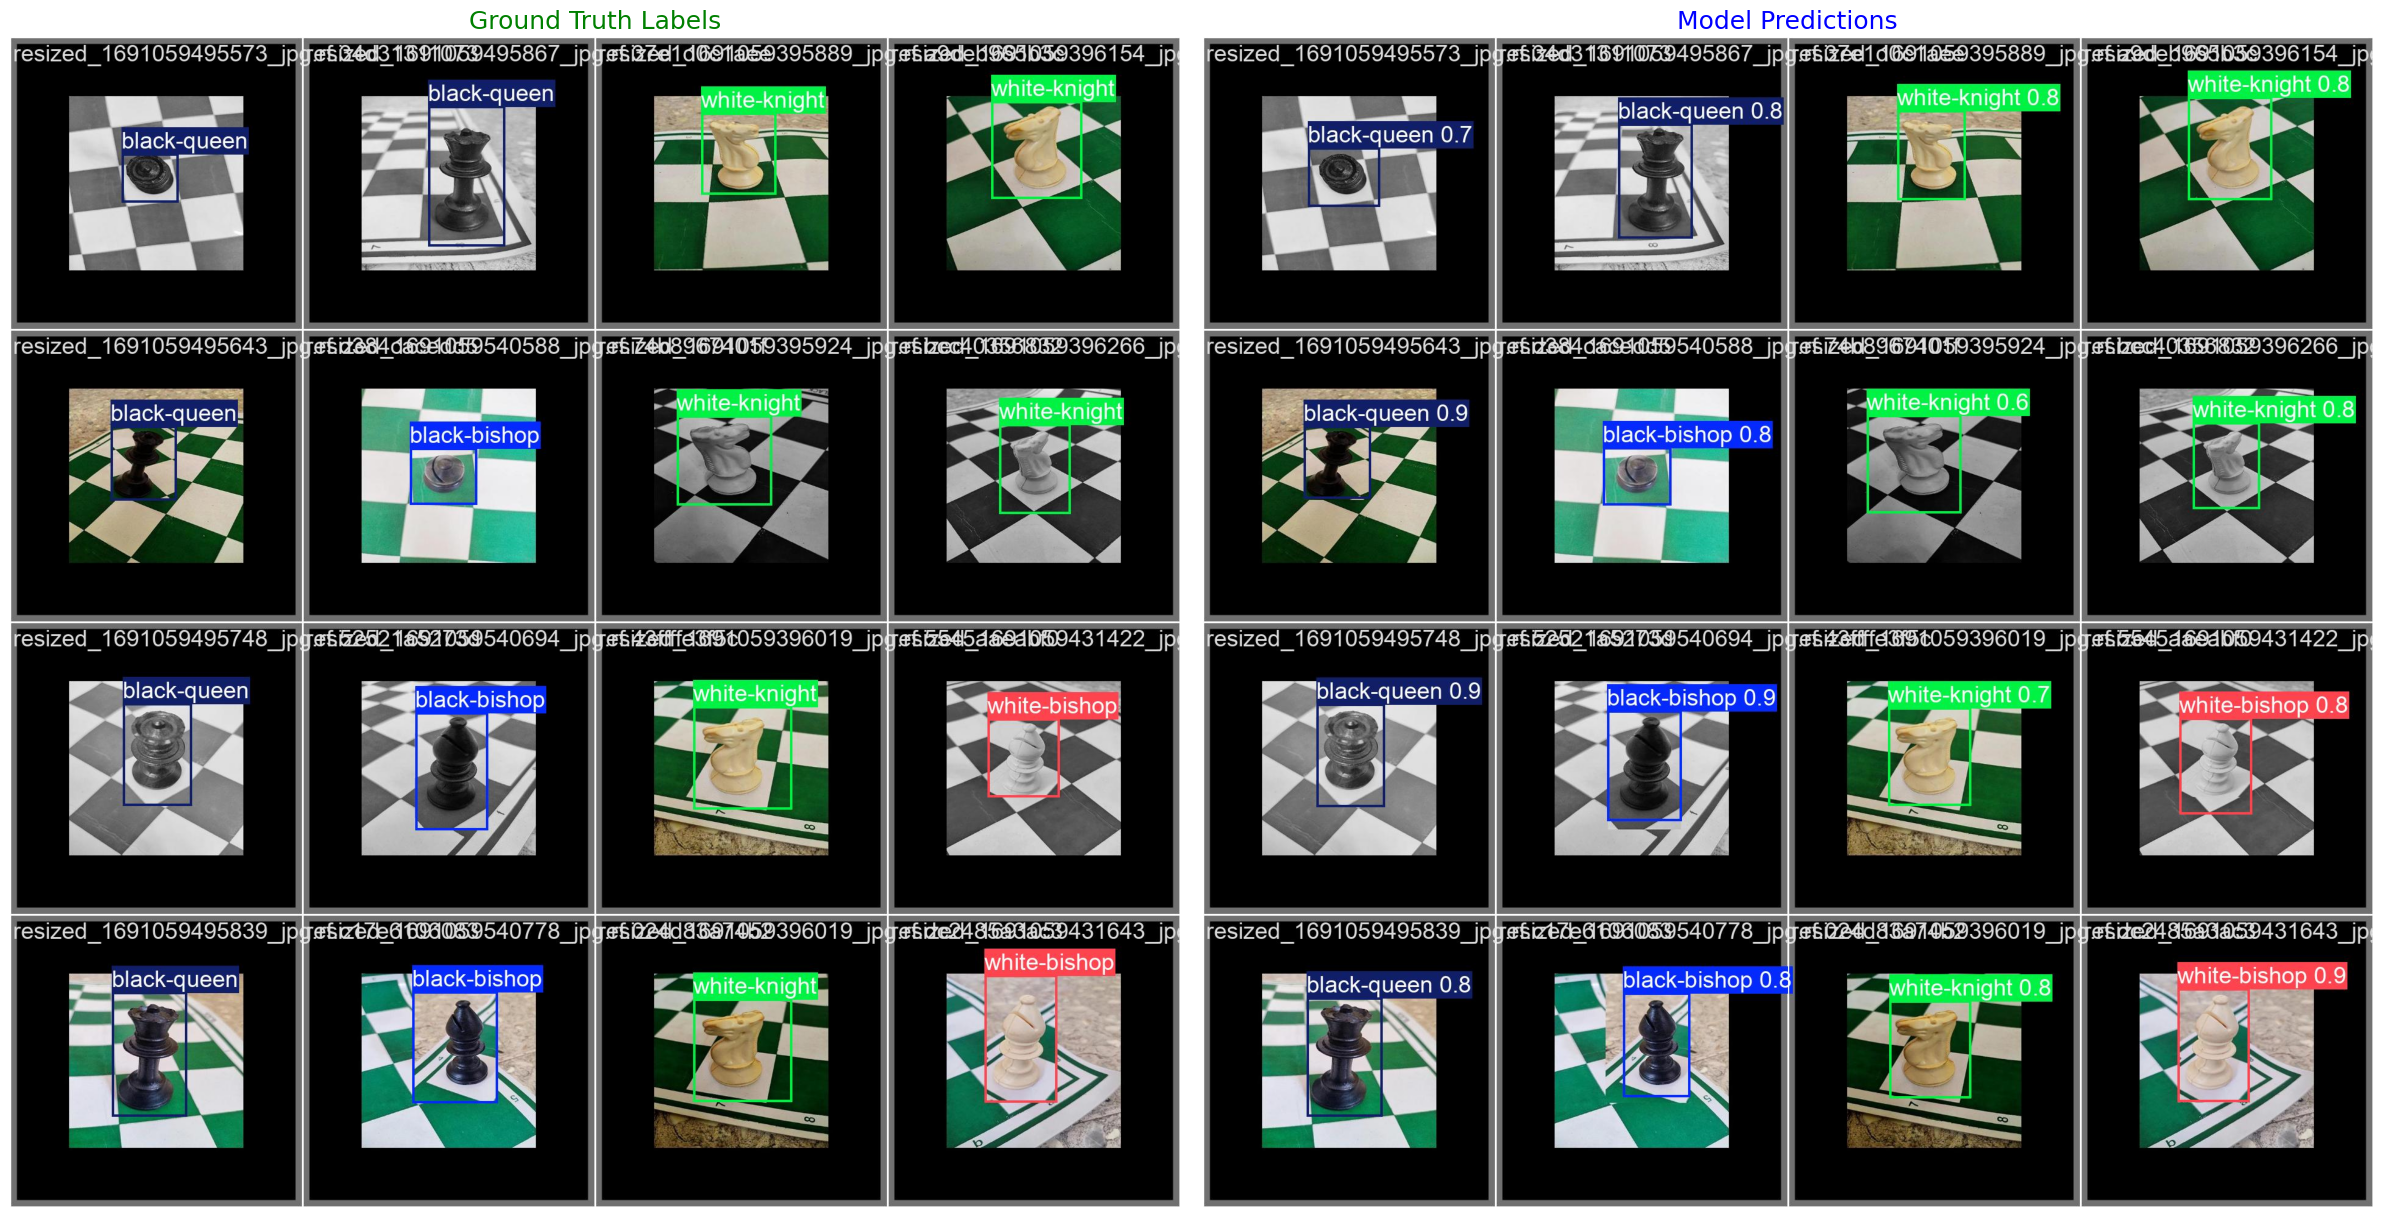


=============== LIVE TEST: Random 3 Images ===============


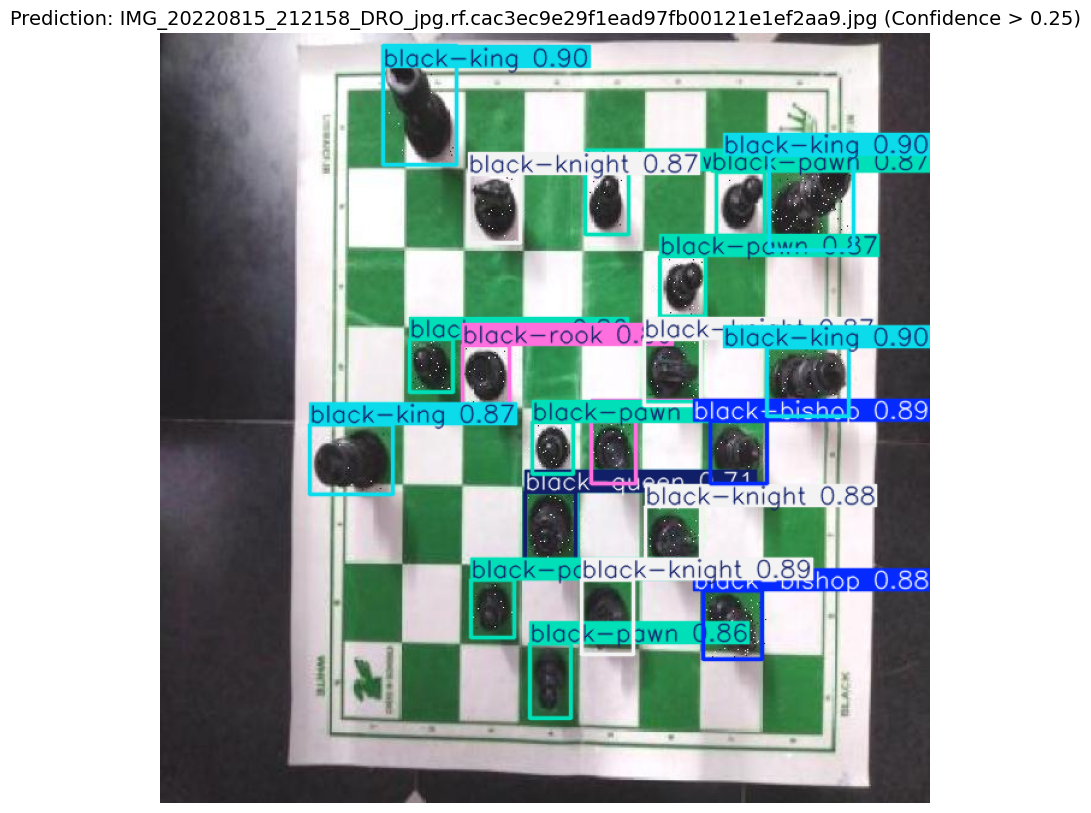

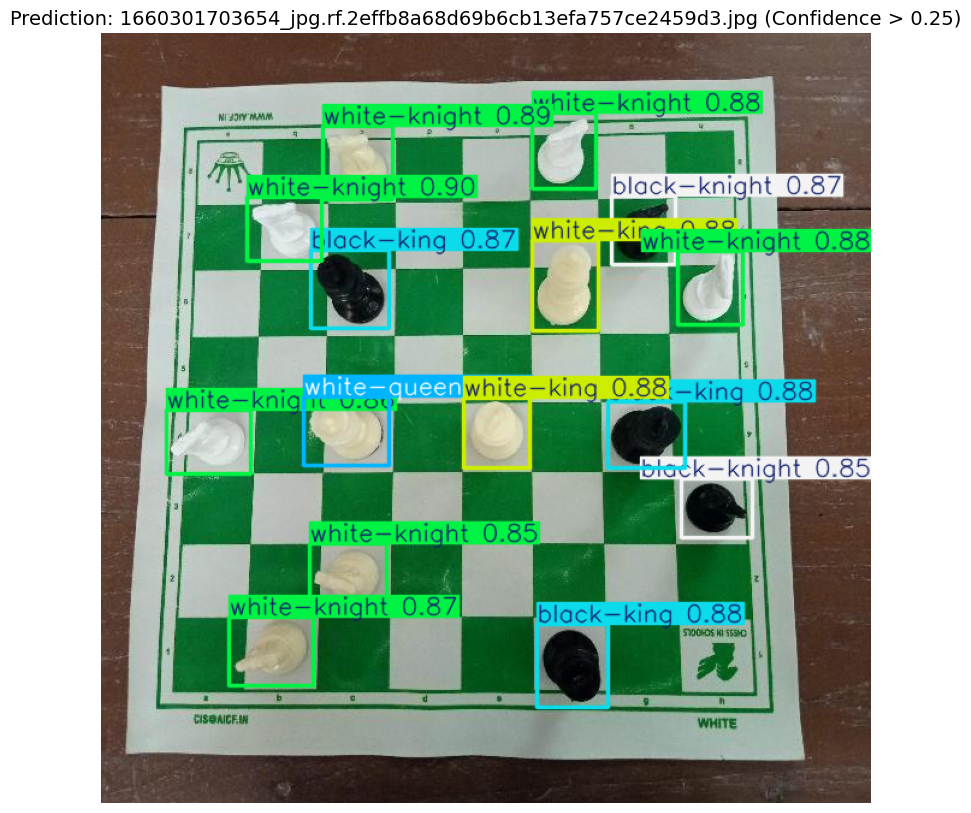

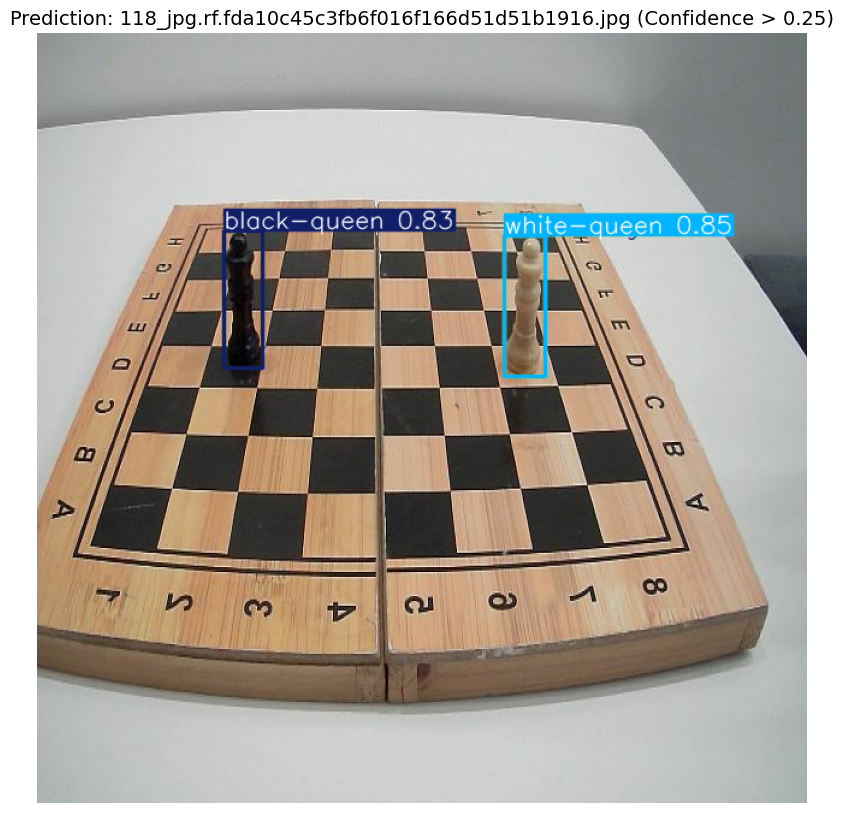

In [ ]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

run_name = 'chess_yolo11s_fast_v1_20251224_1304'

drive_root = '/content/drive/MyDrive/Deep_Learning'

run_dir = os.path.join(drive_root, 'runs', run_name)
best_weights = os.path.join(run_dir, 'weights', 'best.pt')

print(f"Target directory: {run_dir}")

# Check if run directory exists
if not os.path.exists(run_dir):
    print("ERROR: The specified run folder was not found.")
    print(f"Please verify the run name: '{run_name}'")
    print(f"Searched path: {run_dir}")
else:
    print("Run folder found. Starting analysis...")

    test_search_path = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
    found_test = glob.glob(test_search_path)

    if found_test:
        test_images_dir = found_test[0]
        print(f"Loading test images from Drive: {test_images_dir}")
    else:
        test_images_dir = '/content/datasets/c1-zhnfm-1/test/images'

        if not os.path.exists(test_images_dir):
            test_images_dir = '/content/datasets/c1-zhnfm-1/valid/images'
        print(f"Loading test images from local disk: {test_images_dir}")

    # Visualization Functions

    def show_ground_truth_vs_pred():
        print("\n" + "=" * 15 + " TRAINING RESULT: GROUND TRUTH vs PREDICTION " + "=" * 15)

        lbl_path = os.path.join(run_dir, 'val_batch0_labels.jpg')
        pred_path = os.path.join(run_dir, 'val_batch0_pred.jpg')

        if os.path.exists(lbl_path) and os.path.exists(pred_path):
            plt.figure(figsize=(24, 12))

            plt.subplot(1, 2, 1)
            plt.imshow(plt.imread(lbl_path))
            plt.title("Ground Truth Labels", fontsize=18, color='green')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(plt.imread(pred_path))
            plt.title("Model Predictions", fontsize=18, color='blue')
            plt.axis('off')

            plt.tight_layout()
            plt.show()
        else:
            print("WARNING: 'val_batch0' images were not found. Training may not have completed or images were not saved.")

    def show_custom_predictions(num_images=3, conf_thresh=0.25):
        print("\n" + "=" * 15 + f" LIVE TEST: Random {num_images} Images " + "=" * 15)

        if not os.path.exists(best_weights):
            print(f"ERROR: 'best.pt' weights file not found: {best_weights}")
            return

        # Load model
        model = YOLO(best_weights)

        # List test images
        all_images = glob.glob(f"{test_images_dir}/*.jpg")
        if not all_images:
            print(f"ERROR: No .jpg images found in directory: {test_images_dir}")
            return

        # Randomly select images
        selected_files = random.sample(all_images, min(len(all_images), num_images))

        # Run inference
        results = model.predict(
            source=selected_files,
            conf=conf_thresh,
            iou=0.45,
            save=False,
            verbose=False
        )

        for i, r in enumerate(results):
            im_bgr = r.plot(line_width=2, font_size=2, conf=True, labels=True)
            im_rgb = im_bgr[..., ::-1]

            plt.figure(figsize=(12, 10))
            plt.imshow(im_rgb)
            plt.title(
                f"Prediction: {os.path.basename(selected_files[i])} (Confidence > {conf_thresh})",
                fontsize=14
            )
            plt.axis('off')
            plt.show()


    show_ground_truth_vs_pred()
    show_custom_predictions(num_images=3, conf_thresh=0.25)


In [ ]:
!pip install -q roboflow ultralytics pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 117.4 MB/s eta 0:00:00


# Restore Dataset When Colab is Restarted

In [ ]:
import os
from google.colab import drive
from roboflow import Roboflow
from ultralytics import settings

!pip install -q roboflow ultralytics pandas seaborn

if not os.path.exists('/content/drive'):
    print("Mounting Google Drive")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

settings.update({'datasets_dir': '/content/datasets'})

def restore_dataset():
    print("downloading dataset from Roboflow")
    try:
        rf = Roboflow(api_key="8gFJp7Eu2sWslubjUHwI")
        project = rf.workspace("visualizan2").project("c1-zhnfm")
        version = project.version(1)
        dataset = version.download("yolov11")
        print(f"Dataset restored at: {dataset.location}")
        return dataset.location
    except Exception as e:
        print(f"Dataset download failed: {e}")

dataset_path = restore_dataset()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Installing dependencies...
Mounting Google Drive...
Mounted at /content/drive
Re-downloading dataset from Roboflow...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to C1-1 in yolov11:: 100%|██████████| 19546/19546 [00:06<00:00, 2824.97it/s]


Dataset restored at: /content/C1-1


# Analyze Model Confidence

Loading model from: /content/drive/MyDrive/Deep_Learning/runs/chess_yolo11s_fast_v1_20251224_1304/weights/best.pt
Analyzing images in: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images
Processing 976 images sequentially to save memory...


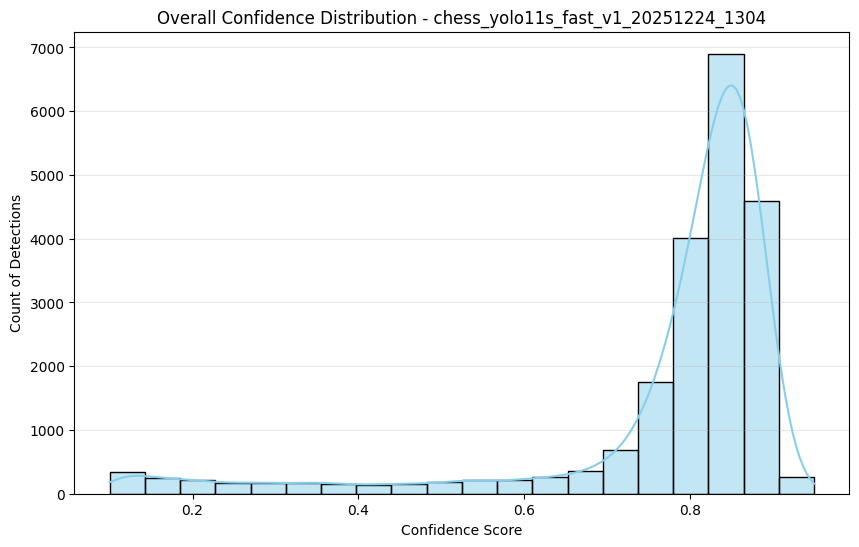



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



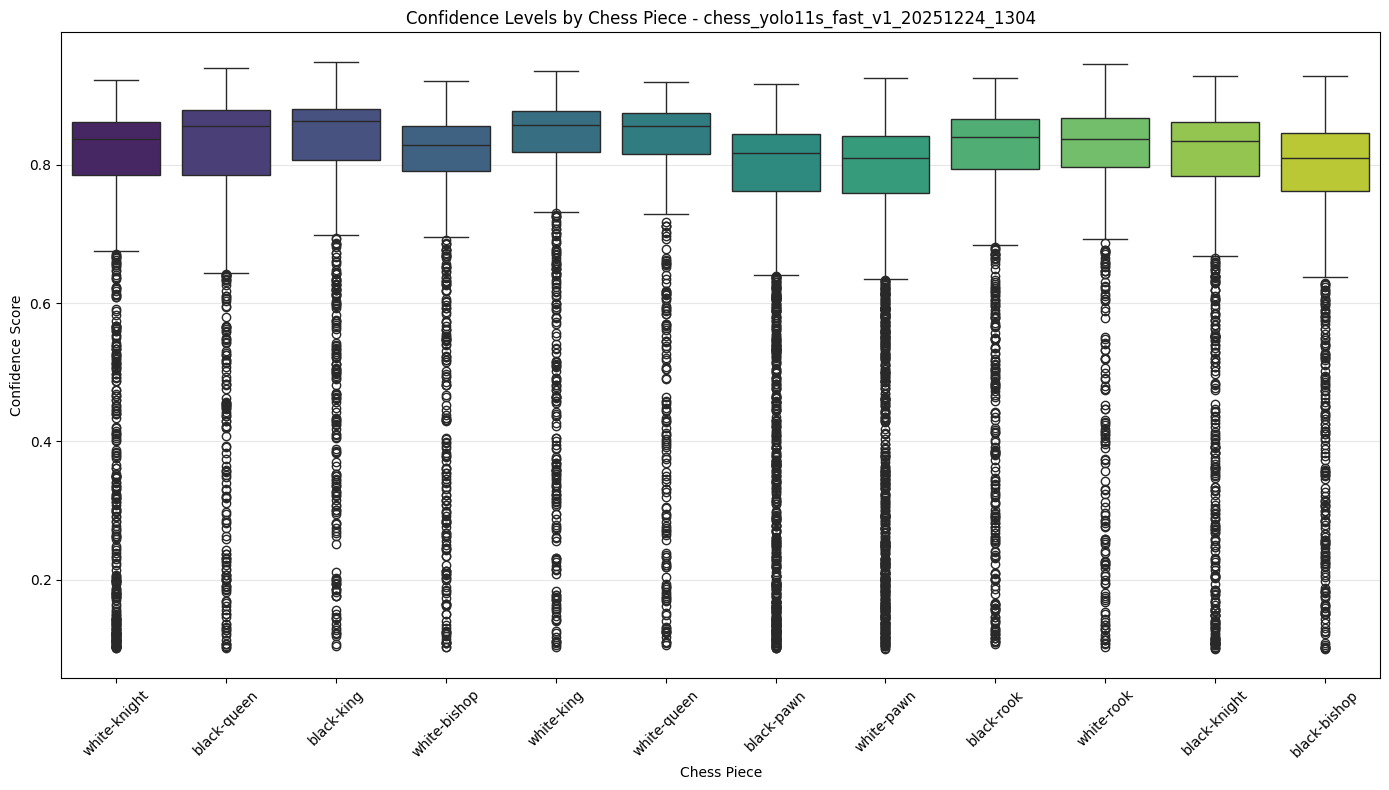

In [ ]:
run_name = 'chess_yolo11s_fast_v1_20251224_1304'

drive_root = '/content/drive/MyDrive/Deep_Learning'
run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

# Locate Test Images
drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    test_images_dir = found_drive_test[0]
else:
    test_images_dir = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(test_images_dir):
        test_images_dir = '/content/datasets/c1-zhnfm-1/valid/images'

def plot_confidence_analysis(model_path, images_dir):
    if torch.cuda.is_available():
        torch.cuda.empty_cache() # Clear GPU memory
        gc.collect()

    if not os.path.exists(model_path):
        print(f"Error: Model weights not found at {model_path}")
        return

    print(f"Loading model from: {model_path}")
    print(f"Analyzing images in: {images_dir}")

    # Load Model
    model = YOLO(model_path)
    image_files = glob.glob(f"{images_dir}/*.jpg")

    if not image_files:
        print("No images found.")
        return

    # Collect data
    all_confs = []
    all_classes = []

    print(f"Processing {len(image_files)} images sequentially to save memory...")

    # We loop through files manually to ensure memory is released after each image
    for i, img_path in enumerate(image_files):
        try:
            results = model.predict(img_path, conf=0.1, verbose=False, device=0) 

            for r in results:
                if r.boxes:
                    confs = r.boxes.conf.cpu().numpy()
                    clss = r.boxes.cls.cpu().numpy().astype(int)
                    class_names = r.names

                    all_confs.extend(confs)
                    all_classes.extend([class_names[c] for c in clss])
        except Exception as e:
            print(f"Skipping image {i} due to error: {e}")
            continue

    df = pd.DataFrame({'Confidence': all_confs, 'Class': all_classes}) # Create DataFrame for plotting

    if df.empty:
        print("No detections made on the test set.")
        return

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Confidence', bins=20, kde=True, color='skyblue')
    plt.title(f'Overall Confidence Distribution - {run_name}')
    plt.xlabel('Confidence Score')
    plt.ylabel('Count of Detections')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df, x='Class', y='Confidence', palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'Confidence Levels by Chess Piece - {run_name}')
    plt.xlabel('Chess Piece')
    plt.ylabel('Confidence Score')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_confidence_analysis(best_model_path, test_images_dir)

# Advanced Evaluation

Analysis started for run: chess_yolo11s_fast_v1_20251224_1304
Model path: /content/drive/MyDrive/Deep_Learning/runs/chess_yolo11s_fast_v1_20251224_1304/weights/best.pt
Test Images: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images

Computing class-wise mAP...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 28.6±15.8 MB/s, size: 68.0 KB)
val: Scanning /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 976/976 1.1Mit/s 0.0s
val: /content/drive/MyDrive/Deep_Learning/datasets/c1-zhnfm-1/test/images/IMG_20200909_000652_jpg.rf.915eb2770aef574ef4eae9a12de1e2b8.jpg: 2 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 61/61 3.3it/s 18.3s
         



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



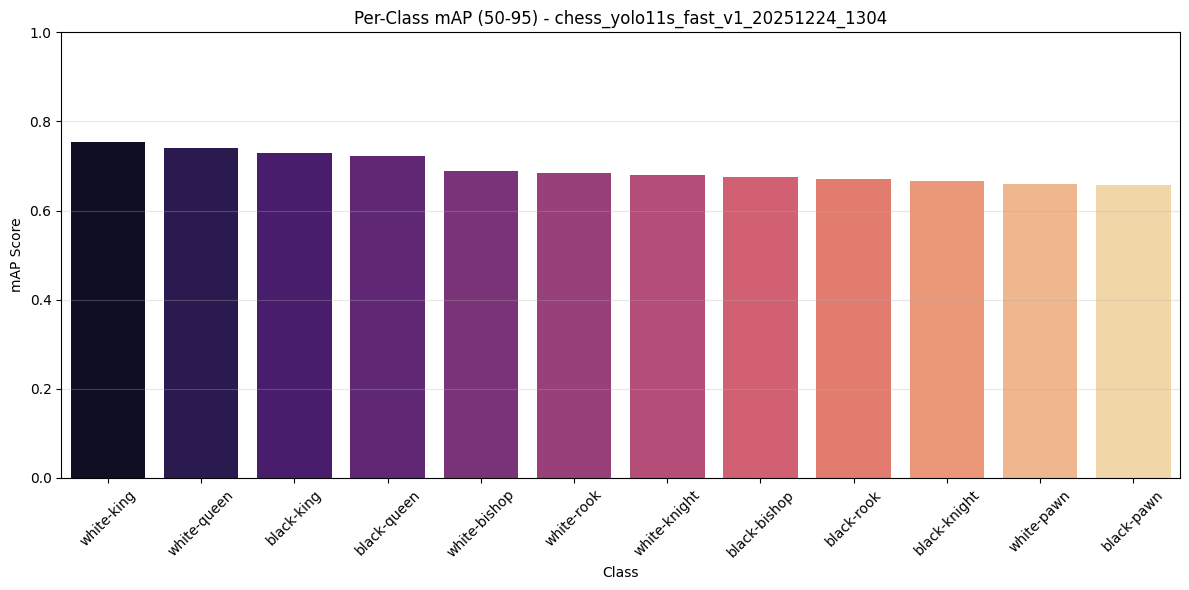


--- Confusion Matrix ---


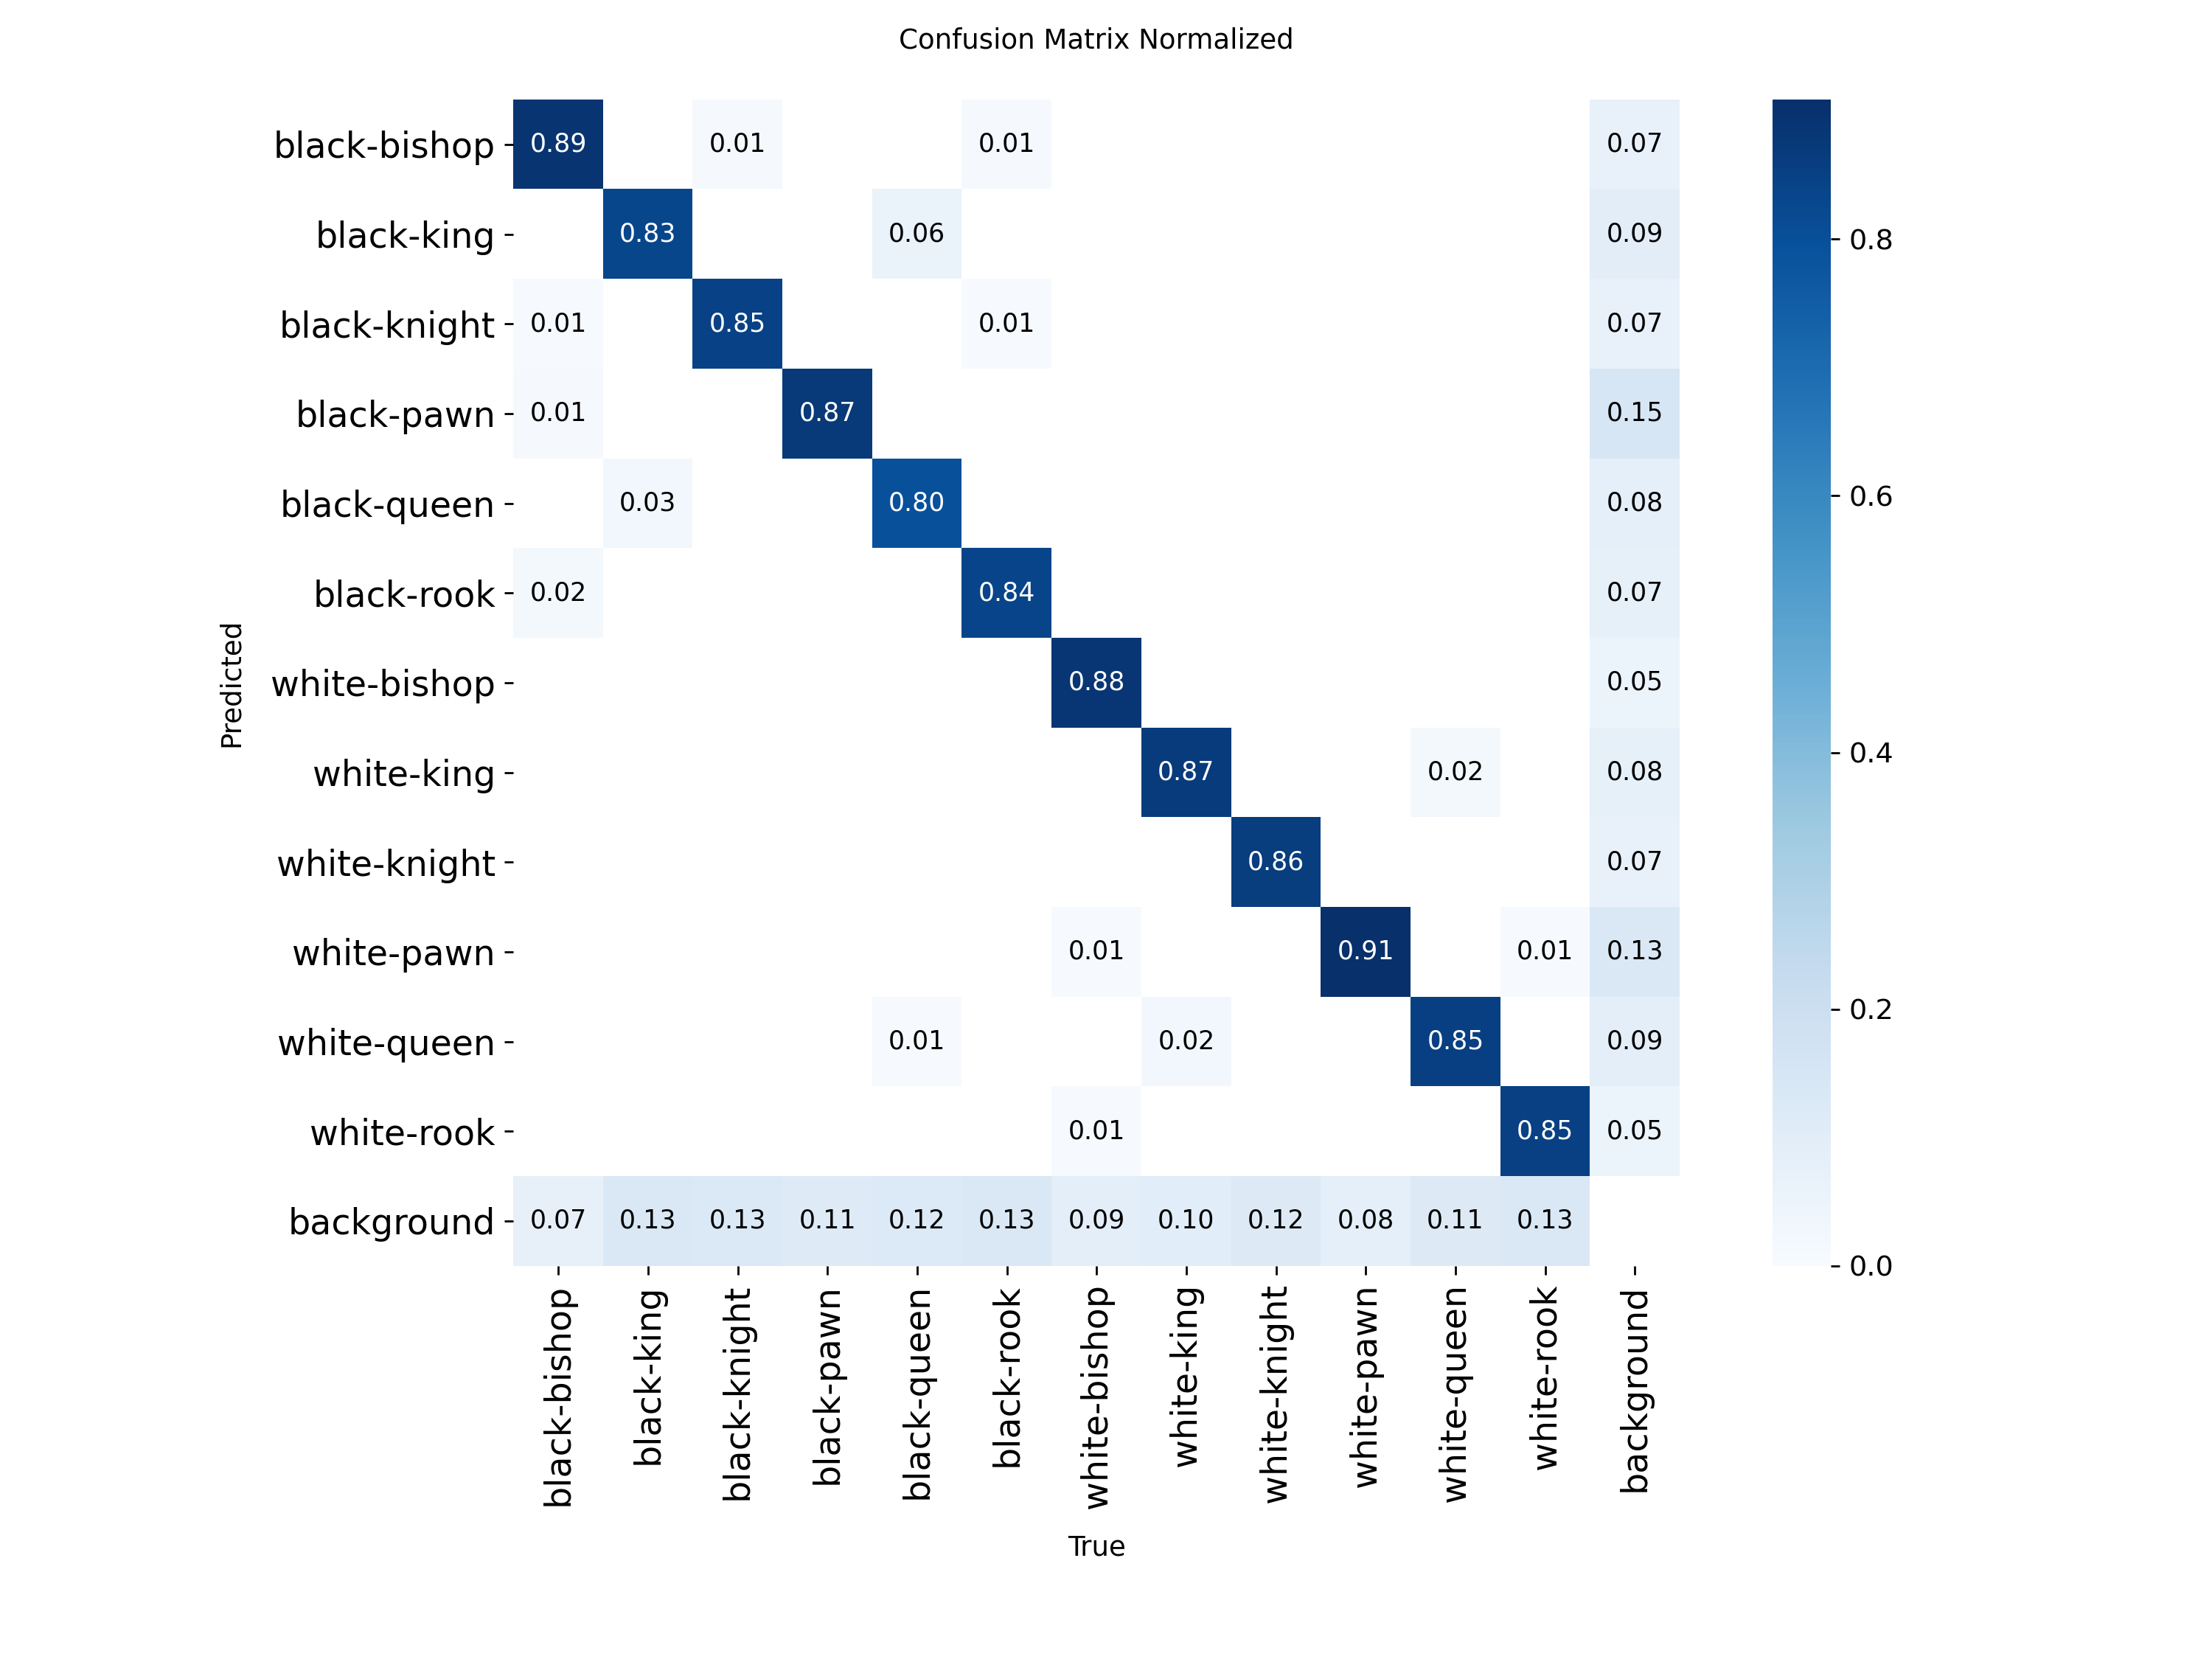


--- 1. Class Distribution Analysis (Ground Truth) ---




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



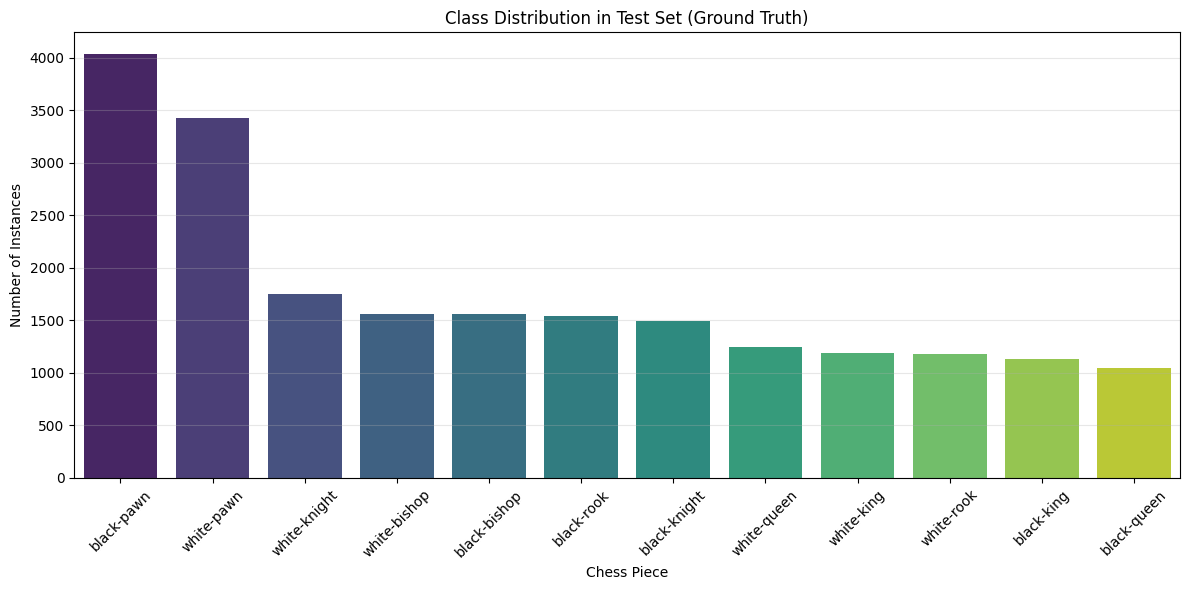


--- 2. Worst Predictions Gallery (Lowest Confidence) ---
Running sequential inference to find hard samples (Memory Safe)...
Plotting 6 worst cases...


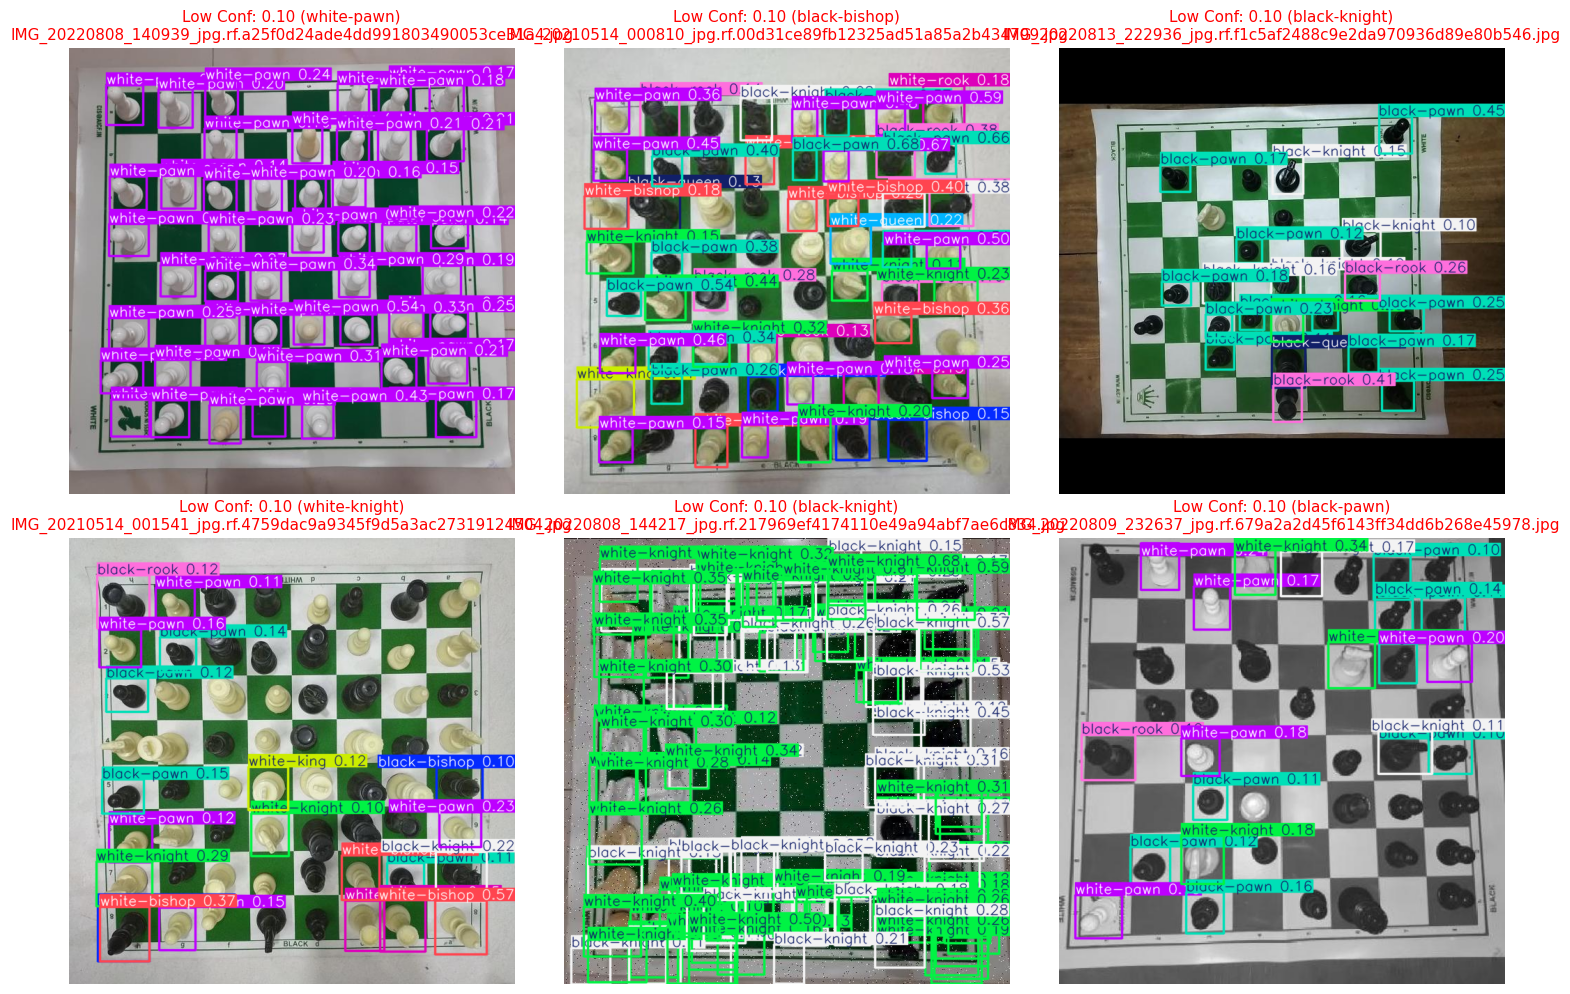

In [ ]:
run_name = 'chess_yolo11s_fast_v1_20251224_1304'

drive_root = '/content/drive/MyDrive/Deep_Learning'
run_dir = os.path.join(drive_root, 'runs', run_name)
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

# Locate Test Images
drive_test_search = os.path.join(drive_root, 'datasets', '*', 'test', 'images')
found_drive_test = glob.glob(drive_test_search)

if found_drive_test:
    test_images_dir = found_drive_test[0]
else:
    test_images_dir = '/content/datasets/c1-zhnfm-1/test/images'
    if not os.path.exists(test_images_dir):
        test_images_dir = '/content/datasets/c1-zhnfm-1/valid/images'

test_labels_dir = test_images_dir.replace('images', 'labels')

print(f"Analysis started for run: {run_name}")
print(f"Model path: {best_model_path}")
print(f"Test Images: {test_images_dir}")

def analyze_class_distribution(class_names):

    print("\n--- 1. Class Distribution Analysis (Ground Truth) ---")

    label_files = glob.glob(os.path.join(test_labels_dir, "*.txt"))
    if not label_files:
        print("No label files found. Skipping distribution plot.")
        return

    class_counts = Counter()

    for lf in label_files:
        with open(lf, 'r') as f:
            lines = f.readlines()
            for line in lines:
                try:
                    cls_id = int(line.split()[0])
                    # Map ID to name using the model's class names
                    if cls_id < len(class_names):
                        class_counts[class_names[cls_id]] += 1
                except ValueError:
                    continue

    if not class_counts:
        print("No classes found in label files.")
        return

    # Create DataFrame
    df_dist = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count']).reset_index()
    df_dist.columns = ['Class', 'Count']
    df_dist = df_dist.sort_values('Count', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_dist, x='Class', y='Count', palette='viridis')
    plt.title('Class Distribution in Test Set (Ground Truth)')
    plt.xlabel('Chess Piece')
    plt.ylabel('Number of Instances')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


def generate_advanced_plots():
    # Clear GPU memory before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    if not os.path.exists(best_model_path):
        print("Model file not found.")
        return

    # Load Model
    model = YOLO(best_model_path)

    #Standard Metrics (mAP)
    print("\nComputing class-wise mAP...")
    metrics = model.val(
        data=os.path.join(os.path.dirname(os.path.dirname(test_images_dir)), 'data.yaml'),
        split='test',
        verbose=False,
        plots=False
    )

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    class_names = metrics.names
    map5095_per_class = metrics.box.maps

    df_map = pd.DataFrame({
        'Class': [class_names[i] for i in range(len(map5095_per_class))],
        'mAP 50-95': map5095_per_class
    }).sort_values('mAP 50-95', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_map, x='Class', y='mAP 50-95', palette='magma')
    plt.title(f'Per-Class mAP (50-95) - {run_name}')
    plt.xlabel('Class')
    plt.ylabel('mAP Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    #Confusion Matrix
    conf_matrix_path = os.path.join(run_dir, 'confusion_matrix_normalized.png')
    if os.path.exists(conf_matrix_path):
        print("\n--- Confusion Matrix ---")
        display(Image(filename=conf_matrix_path, width=800))

    # Class Distribution
    analyze_class_distribution(class_names)


generate_advanced_plots()

# Compare Models on Custom Images We Provide

In [ ]:
custom_images_path = '/content/drive/MyDrive/Deep_Learning/Custom_images'

yolo_weights_path = '/content/drive/MyDrive/Deep_Learning/runs/chess_yolo11s_fast_v1_20251224_1304/weights/best.pt'

detr_weights_path = '/content/drive/MyDrive/Deep_Learning/runs/chess_rtdetr_l_20251224_1436/weights/best.pt'

# Confidence Threshold 
conf_threshold = 0.5


def run_comparative_inference():
    if not os.path.exists(custom_images_path):
        print(f"Error: Image folder not found at {custom_images_path}")
        return
    if not os.path.exists(yolo_weights_path):
        print(f"Error: YOLO weights not found at {yolo_weights_path}")
        return
    if not os.path.exists(detr_weights_path):
        print(f"Error: DETR weights not found at {detr_weights_path}")
        return

    # Load Models
    print("Loading models.")
    try:
        yolo_model = YOLO(yolo_weights_path)

        try:
            detr_model = RTDETR(detr_weights_path)
        except:
            detr_model = YOLO(detr_weights_path) # Fallback

        print("Models loaded successfully.")
    except Exception as e:
        print(f"Error loading models: {e}")
        return

    # Get Images
    image_files = glob.glob(os.path.join(custom_images_path, "*.*"))
    # Filter for valid image extensions
    valid_exts = ['.jpg', '.jpeg']
    image_files = [f for f in image_files if os.path.splitext(f)[1].lower() in valid_exts]

    if not image_files:
        print(f" No images found in {custom_images_path}")
        return

    print(f"Found {len(image_files)} images. Starting inference\n")

    # Inference and Visualization Loop
    for i, img_path in enumerate(image_files):
        filename = os.path.basename(img_path)
        print(f"Processing image {i+1}/{len(image_files)}: {filename}")

        # Run Predictions
        yolo_results = yolo_model.predict(img_path, conf=conf_threshold, verbose=False, device=0)
        detr_results = detr_model.predict(img_path, conf=conf_threshold, verbose=False, device=0)

        # Plotting Setup
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))

        # Original Image
        img_original = plt.imread(img_path)
        axes[0].imshow(img_original)
        axes[0].set_title("Original Image", fontsize=16)
        axes[0].axis('off')

        #   YOLO Prediction
        yolo_plot = yolo_results[0].plot(line_width=1, font_size=1)
        axes[1].imshow(yolo_plot[..., ::-1])
        axes[1].set_title(f"YOLOv11 Prediction\n({os.path.basename(yolo_weights_path)})", fontsize=16, color='blue')
        axes[1].axis('off')

        #  RT-DETR Prediction
        detr_plot = detr_results[0].plot(line_width=1, font_size=1)
        axes[2].imshow(detr_plot[..., ::-1])
        axes[2].set_title(f"RT-DETR Prediction\n({os.path.basename(detr_weights_path)})", fontsize=16, color='purple')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        print("-" * 80)

run_comparative_inference()

# WE DELETED THE OUTPUT OF THE CELL SINCE OUR TOTAL FILE SIZE EXCEEDED 50 MB